In [1]:
import math
import os
import random
import shutil
import pickle
import matplotlib.colors
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
import tensorflow as tf
import shap
import sys
from simple_colors import *

from scipy.stats import ttest_ind
from scipy.special import softmax
from sklearn.metrics import accuracy_score
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer

SEED_VALUE = 11
os.environ['PYTHONHASHSEED']=str(SEED_VALUE)
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)
warnings.filterwarnings('ignore')
os.chdir(os.getcwd())

from analysis.dataset_composition import Dataset_composition
from analysis.corrects_distribution import Corrects_distribution
from analysis.sentiment_accuracy import Sentiment_accuracy
from analysis.mask_accuracy import Mask_accuracy
from analysis.contrast_accuracy import Contrast_accuracy
from analysis.lime_explanation_accuracy import Lime_explanation_accuracy

In [4]:
SHOW_RESULTS = "percy" #accuracy, percy

base_models = ["rnn_model", 
               "birnn_model", 
               "gru_model", 
               "bigru_model", 
               "lstm_model", 
               "bilstm_model"]

mask_models = []
masks = ["rnn", "birnn", "gru", "bigru", "lstm", "bilstm"]    
for mask in masks:
    models = ["rnn_"+mask+"_mask_model", "birnn_"+mask+"_mask_model", "gru_"+mask+"_mask_model", "bigru_"+mask+"_mask_model", "lstm_"+mask+"_mask_model", "bilstm_"+mask+"_mask_model"] 
    mask_models.append(models)    

cwe = ["rnn_model-ELMO", 
       "birnn_model-ELMO",
       "gru_model-ELMO", 
       "bigru_model-ELMO", 
       "lstm_model-ELMO",        
       "bilstm_model-ELMO"]

ikd = ["rnn_model-IKD-PAD_MASK_ZERO", 
       "birnn_model-IKD-PAD_MASK_ZERO",        
       "gru_model-IKD-PAD_MASK_ZERO",
       "bigru_model-IKD-PAD_MASK_ZERO", 
       "lstm_model-IKD-PAD_MASK_ZERO", 
       "bilstm_model-IKD-PAD_MASK_ZERO"]

RNN = []
BiRNN = []
GRU = []
BiGRU = []
LSTM = []
BiLSTM = []

def append_to_model(model, results_base, results_base_lime_explanations):
    
    one_rule = pd.concat([results_base.loc[(results_base["rule_label"]!=0)&(results_base["contrast"]==1)], results_base.loc[(results_base["rule_label"]!=0)&(results_base["contrast"]==0)]])
    one_rule = one_rule.reset_index(drop=True)
    one_rule_contrast_pos = one_rule.loc[(one_rule["contrast"]==1)&(one_rule["sentiment_label"]==1)]
    one_rule_contrast_neg = one_rule.loc[(one_rule["contrast"]==1)&(one_rule["sentiment_label"]==0)]
    one_rule_contrast_pos_sample = one_rule_contrast_pos.sample(n=1350, random_state=11)
    one_rule_contrast_neg_sample = one_rule_contrast_neg.sample(n=1351, random_state=11)
    one_rule.drop(one_rule_contrast_pos_sample.index, inplace = True)
    one_rule.drop(one_rule_contrast_neg_sample.index, inplace = True)
    results_base = pd.concat([results_base.loc[results_base["rule_label"]==0], one_rule])
    results_base = results_base.reset_index(drop=True)
    results_base_lime_explanations.drop(one_rule_contrast_pos_sample.index, inplace = True)
    results_base_lime_explanations.drop(one_rule_contrast_neg_sample.index, inplace = True)
    results_base_lime_explanations = results_base_lime_explanations.reset_index(drop=True)
    
    base_sent_corrects = Corrects_distribution(len(results_base['sentence'])).model_sentiment_correct_distributions(results_base)
    base_lime_corrects = Corrects_distribution(len(results_base['sentence'])).model_lime_correct_distributions(results_base, results_base_lime_explanations)    
    
    mean_sent_value = sum(base_sent_corrects['one_rule_contrast'])/len(base_sent_corrects['one_rule_contrast'])
    mean_sent_value = round(mean_sent_value, 3)
    mean_lime_value = sum(base_lime_corrects['one_rule_contrast'])/len(base_lime_corrects['one_rule_contrast'])
    mean_lime_value = round(mean_lime_value, 3)
    
    global SHOW_RESULTS
    global RNN
    global BiRNN
    global GRU
    global BiGRU
    global LSTM
    global BiLSTM
    
    if SHOW_RESULTS == "percy":
        if model.split("_")[0] == "rnn":
            RNN.append(mean_lime_value)
        elif model.split("_")[0] == "birnn":
            BiRNN.append(mean_lime_value)
        elif model.split("_")[0] == "gru":
            GRU.append(mean_lime_value)
        elif model.split("_")[0] == "bigru":
            BiGRU.append(mean_lime_value)
        elif model.split("_")[0] == "lstm":
            LSTM.append(mean_lime_value)
        elif model.split("_")[0] == "bilstm":
            BiLSTM.append(mean_lime_value)
    elif SHOW_RESULTS == "accuracy":
        if model.split("_")[0] == "rnn":
            RNN.append(mean_sent_value)
        elif model.split("_")[0] == "birnn":
            BiRNN.append(mean_sent_value)
        elif model.split("_")[0] == "gru":
            GRU.append(mean_sent_value)
        elif model.split("_")[0] == "bigru":
            BiGRU.append(mean_sent_value)
        elif model.split("_")[0] == "lstm":
            LSTM.append(mean_sent_value)
        elif model.split("_")[0] == "bilstm":
            BiLSTM.append(mean_sent_value)

for model in base_models:
    with open("base_model/assets/results/"+model+".pickle", 'rb') as handle:
        results_base = pickle.load(handle)
        results_base = pd.DataFrame(results_base)
    with open("base_model/assets/lime_explanations/"+model+".pickle", 'rb') as handle:
        results_base_lime_explanations = pickle.load(handle)
        results_base_lime_explanations = pd.DataFrame(results_base_lime_explanations)
        
    append_to_model(model, results_base, results_base_lime_explanations)
        
for model in ikd:
    with open("IKD/assets/results/"+model+".pickle", 'rb') as handle:
        results_base = pickle.load(handle)
        results_base = pd.DataFrame(results_base)
    with open("IKD/assets/lime_explanations/"+model+".pickle", 'rb') as handle:
        results_base_lime_explanations = pickle.load(handle)
        results_base_lime_explanations = pd.DataFrame(results_base_lime_explanations)
    
    append_to_model(model, results_base, results_base_lime_explanations)
        
for model in cwe:
    with open("CWE/assets/results/"+model+".pickle", 'rb') as handle:
        results_base = pickle.load(handle)
        results_base = pd.DataFrame(results_base)
    with open("CWE/assets/lime_explanations/"+model+".pickle", 'rb') as handle:
        results_base_lime_explanations = pickle.load(handle)
        results_base_lime_explanations = pd.DataFrame(results_base_lime_explanations)
    
    append_to_model(model, results_base, results_base_lime_explanations)

for mask_model in mask_models:
    for model in mask_model:
        with open("mask_model/assets/results/"+model+".pickle", 'rb') as handle:
            results_base = pickle.load(handle)
            results_base = pd.DataFrame(results_base)
        with open("mask_model/assets/lime_explanations/"+model+".pickle", 'rb') as handle:
            results_base_lime_explanations = pickle.load(handle)
            results_base_lime_explanations = pd.DataFrame(results_base_lime_explanations)
    
        append_to_model(model, results_base, results_base_lime_explanations)

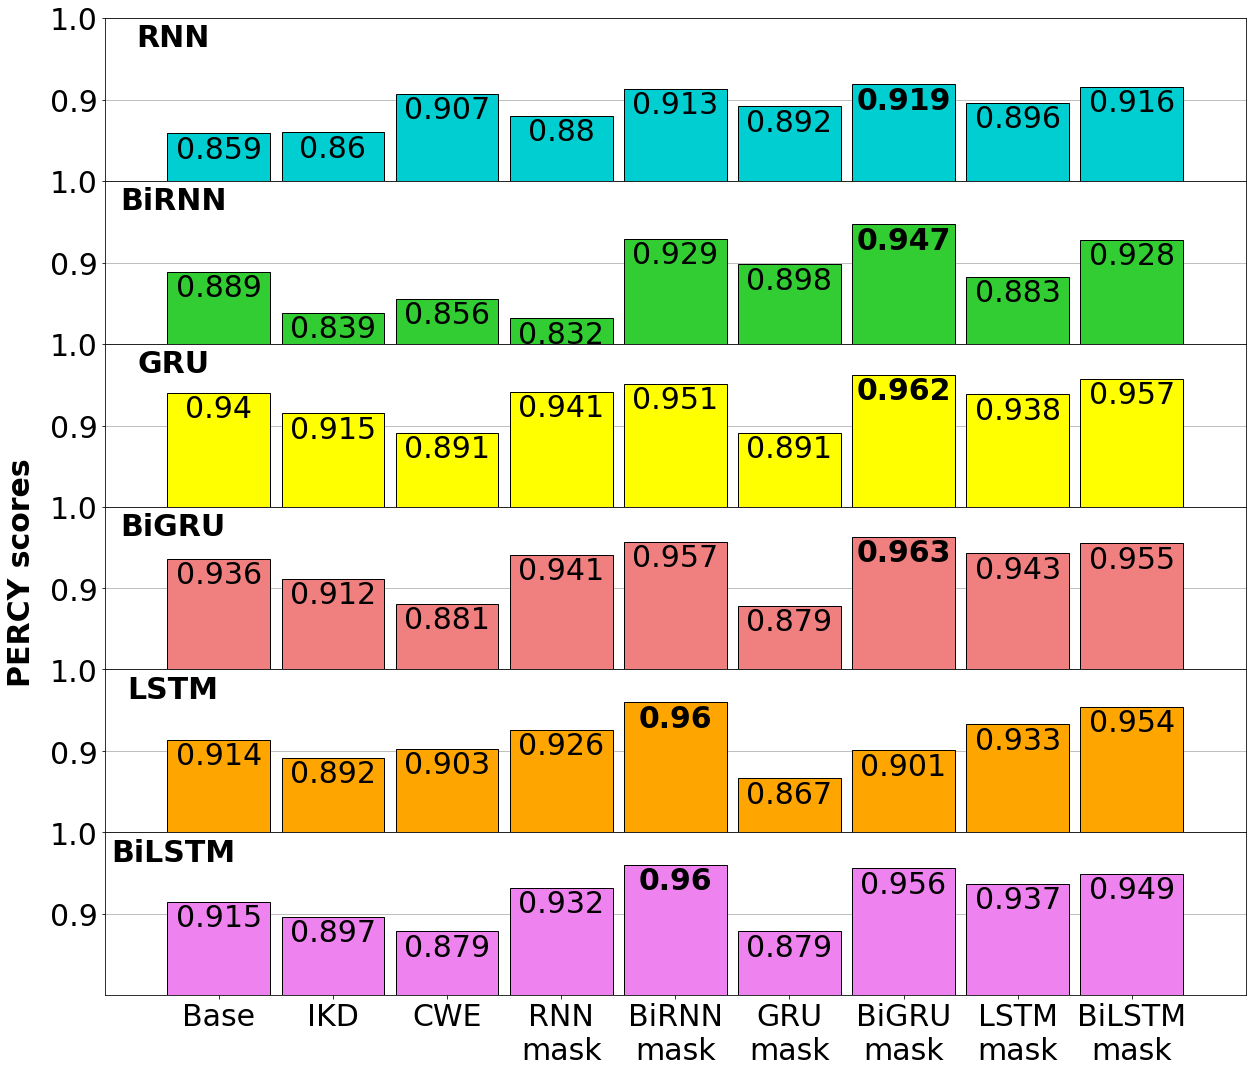

In [5]:
# Bar plots for ECIR draft
models = ["RNN", "BiRNN", "GRU", "BiGRU", "LSTM", "BiLSTM"]
clrs = ["darkturquoise", "limegreen", "yellow", "lightcoral", "orange", "violet"]
#["blue", "orange", "green", "red", "limegreen", "brown", "magenta", "grey", "darkturquoise", "olive"]

params = {'legend.fontsize': 25,
        'axes.labelsize': 30,
        'axes.titlesize': 30,
        'xtick.labelsize': 30,
        'ytick.labelsize': 30,
        'axes.titlepad': 12,
        'axes.axisbelow': True,
        'text.usetex': False,
        'text.latex.preamble': r'\usepackage{amsmath}\usepackage{type1cm}'}
plt.rcParams.update(params)

fig_acc, axs = plt.subplots(6, 1, figsize=(20, 15))

# Bar Plots
for ind, (ax, model) in enumerate(zip(axs, models)):
    
    ax.yaxis.grid(True)
    ax.set_title(model, x=0.06, y=0.75, fontweight='bold')

    labels = ["Base", "IKD", "CWE", "RNN\nmask", "BiRNN\nmask", "GRU\nmask", "BiGRU\nmask", "LSTM\nmask", "BiLSTM\nmask"]

    width = 0.9
    x_coordinates = [index for index, value in enumerate(labels)]
    
    colors = iter([clrs[ind]]*(len(labels)))
    
    rnn = globals()[model]
    
    for index, _ in enumerate(labels):
        x_coordinate = x_coordinates[index]
        mean = rnn[index]
        max_val_index = rnn.index(max(rnn))
        stat_similar_val_indices = []
        for i, val in enumerate(rnn):
            if max(rnn)-val < 0.03 and max(rnn)-val != 0.0:
                stat_similar_val_indices.append(i)
        color = next(colors)
        bars = ax.bar(x_coordinate, mean, width, edgecolor = 'black', linewidth = 1, color=color)
    #     error_bars = ax.errorbar(x_coordinate, mean, yerr=std_dev, fmt='o', marker='.', capsize=3, capthick=1, markersize=3, elinewidth=0, color='black')
        for rect in bars:
            height = rect.get_height()
            if index == max_val_index:
                ax.text(x=rect.get_x() + rect.get_width() / 2, y=height-0.03, s="{}".format(height), ha='center', fontsize='30', rotation=0, weight='bold')
#             elif index in stat_similar_val_indices:
#                 value = str(height)
# #                 print(value)
#                 ax.text(x=rect.get_x() + rect.get_width() / 2, y=height+0.02, s=r'$\underline{'+value+'}$', ha='center', fontsize='30', rotation=0, usetex=True)
            else:
                ax.text(x=rect.get_x() + rect.get_width() / 2, y=height-0.03, s="{}".format(height), ha='center', fontsize='30', rotation=0)

    #     ax.plot(correct_means, '-o', color='black', linewidth=3)
    if model == "GRU":
        if SHOW_RESULTS == "percy":
            ax.set_ylabel('PERCY scores', fontweight='bold')
            ax.yaxis.set_label_coords(-0.06, -0.4)
        elif SHOW_RESULTS == "accuracy":
            ax.set_ylabel('Accuracy', fontweight='bold')
            ax.yaxis.set_label_coords(-0.06, -0.4)
    ax.set_xticks(x_coordinates)
    if model == "BiLSTM":
        ax.set_xticklabels(labels, rotation=0, ha="center")
    ax.set_xlim(-1, len(labels))
    ax.set_ylim(0.801, 1.0)
    
    if model != "BiLSTM":
        ax.xaxis.set_visible(False)
        ax.spines['bottom'].set_visible(False)

    plt.tight_layout()
    plt.subplots_adjust(left=0.2, bottom=None, right=None, top=None, wspace=None, hspace=0)

# Save fig
if not os.path.exists("analysis/ECIR2023/"):
    os.makedirs("analysis/ECIR2023/")
plt.savefig('analysis/ECIR2023/bar_plots.eps', bbox_inches = 'tight')

# Display fig
plt.show()

In [ ]:
## Covid-19 dataset ##
